In [1]:
import sys

sys.path.append("../src")

In [2]:
import importlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import lib
import common

importlib.reload(lib)

<module 'lib' from '/Users/r/Documents/stud/ss24/finnpinn/news/../src/lib.py'>

In [3]:
core1_data = lib.load_exp_data_numpy("Core 1")
core2_data = lib.load_exp_data_numpy("Core 2")
core2b_data = lib.load_exp_data_numpy("Core 2b")

In [4]:
# new_mcmc_samples = lib.ExperimentalSamples.from_dir(
#     "../data_processed/experimental/MCMC/"
# )

# mcmc_samples = lib.ExperimentalSamples.from_dir("../data/mcmc_samples/")
# fig, axs = mcmc_samples.plot(only_outlines=True, line_kwargs=dict(color="red"))
# new_mcmc_samples.plot(axs, only_outlines=True, line_kwargs=dict(color="green"))

# axs[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
# axs[1].scatter(*core2_data, color="red", alpha=0.3)
# axs[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)

# plt.tight_layout()
# plt.show()

# Reproduced MCMC (Barker Sampler) Results

In [5]:
def hists_over_x(samples: np.ndarray, fit_guassians=False, ax=None, **hist_kwargs):
    hist_kwargs.setdefault("bins", 20)
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 3))

    for k, i in enumerate(
        np.linspace(8, samples.shape[1] - 1, 6, endpoint=True, dtype=int)
    ):
        data = samples[:, i]
        dens, bin_edges = np.histogram(data, **hist_kwargs)
        bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2).reshape(-1, 1)
        x_scaler = MinMaxScaler().fit(bin_centers)
        bin_centers = x_scaler.transform(bin_centers)
        bin_centers += k
        ax.plot(bin_centers, dens)

        if fit_guassians:
            loc, scale = stats.norm.fit(data)
            distr = stats.norm(loc, scale)
            x = np.linspace(data.min(), data.max(), 100).reshape(-1, 1)
            std_norm = distr.pdf(x)
            std_norm /= std_norm.max()
            std_norm *= dens.max()
            x = x_scaler.transform(x)
            x += k
            ax.plot(x, std_norm, "k--")

    return plt.gcf(), ax

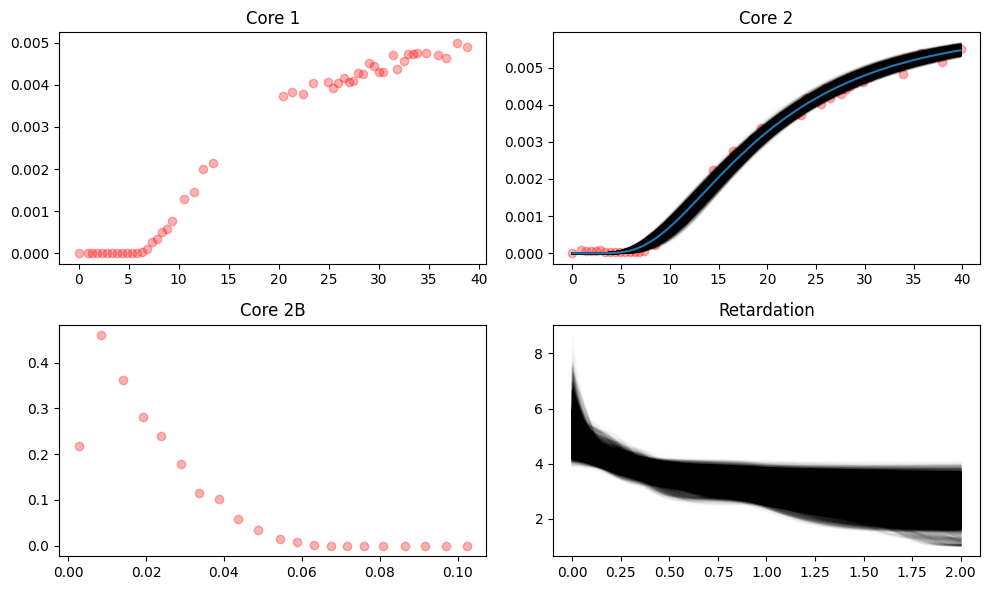

In [6]:
mcmc_samples = lib.ExperimentalSamples.from_dir("../data_processed/experimental/MCMC/")
fig, axs = mcmc_samples.plot()

axs[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)
axs[1].plot(core2_data[0], np.median(mcmc_samples.core2, axis=0), "-", color="C0")


plt.tight_layout()
fig.savefig("../paper/figs/finn_mcmc_samples.png")
plt.show()

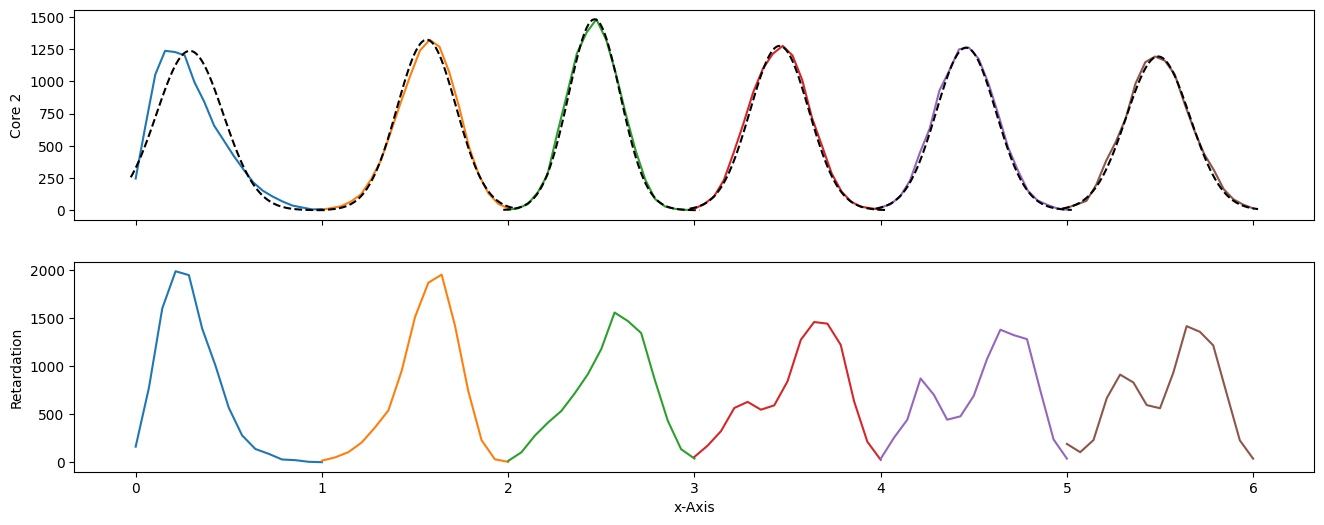

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 6), sharex=True)
axs[0].set_ylabel("Core 2")
axs[1].set_ylabel("Retardation")
axs[1].set_xlabel("x-Axis")
hists_over_x(mcmc_samples.core2, ax=axs[0], fit_guassians=True)
hists_over_x(mcmc_samples.ret_y, ax=axs[1], fit_guassians=False, bins=15)
plt.show()

## Comparison with paper PI

In [8]:
PI_PLOT_KWARGS = dict(
    alpha=0.3,
    edgecolor="none",
    zorder=-10,
)

In [9]:
upper_my_mcmc_ret_90 = np.quantile(mcmc_samples.ret_y, 0.95, axis=0)
lower_my_mcmc_ret_90 = np.quantile(mcmc_samples.ret_y, 0.05, axis=0)
upper_my_mcmc_core2_90 = np.quantile(mcmc_samples.core2, 0.95, axis=0)
lower_my_mcmc_core2_90 = np.quantile(mcmc_samples.core2, 0.05, axis=0)

In [10]:
_, _, upper_mcmc_PI_core2, lower_mcmc_PI_core2, u_data, _, _, _ = (
    common.load_mcmc_paper_curves(t_eval=core2_data[0])
)

n_inside_my = np.count_nonzero(
    (core2_data[1] <= upper_my_mcmc_core2_90)
    & (core2_data[1] >= lower_my_mcmc_core2_90)
)
n_inside_his = np.count_nonzero(
    (core2_data[1] <= upper_mcmc_PI_core2) & (core2_data[1] >= lower_mcmc_PI_core2)
)

print(f" My Core 2 PI contains: {n_inside_my/len(core2_data[1]):.1%}")
print(f"His Core 2 PI contains: {n_inside_his/len(core2_data[1]):.1%}")

 My Core 2 PI contains: 54.5%
His Core 2 PI contains: 78.2%


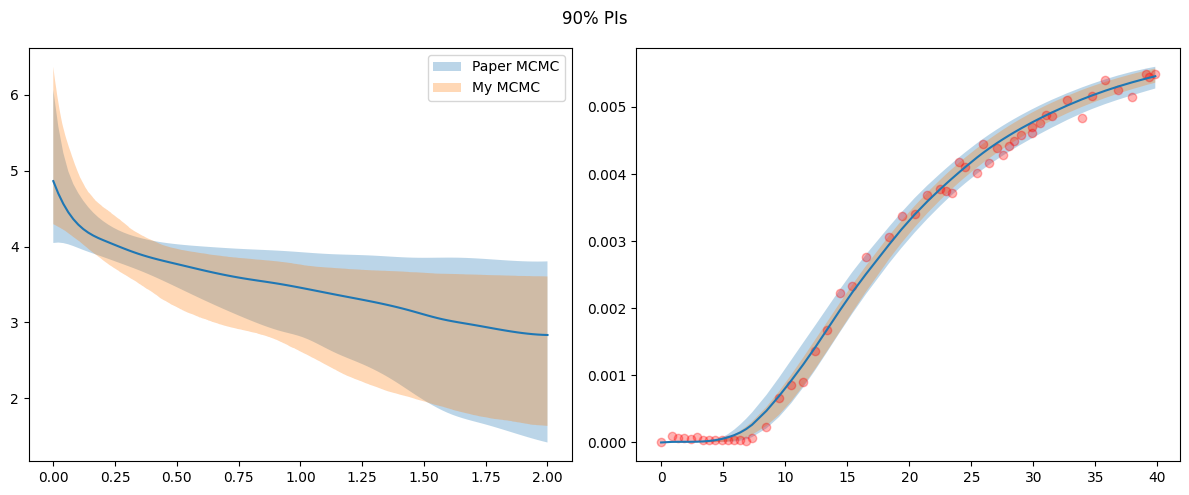

In [11]:
(
    t_eval,
    mean_core2_paper,
    upper_mcmc_PI_core2,
    lower_mcmc_PI_core2,
    u_eval,
    mean_ret_core2_paper,
    upper_ret_mcmc_PI_core2_paper,
    lower_ret_mcmc_PI_core2_paper,
) = common.load_mcmc_paper_curves(t_eval=lib.load_exp_data_numpy("Core 2")[0])
paper_mcmc_samples = lib.ExperimentalSamples(
    core1=(None, None),
    core2=np.array([upper_mcmc_PI_core2, lower_mcmc_PI_core2]),
    core2b=(None, None),
    ret_x=u_eval,
    ret_y=np.array([upper_ret_mcmc_PI_core2_paper, lower_ret_mcmc_PI_core2_paper]),
)

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
fig.suptitle("90% PIs")
axs[0].plot(u_eval, mean_ret_core2_paper, "-", color="C0")
axs[0].fill_between(
    u_eval,
    lower_ret_mcmc_PI_core2_paper,
    upper_ret_mcmc_PI_core2_paper,
    color="C0",
    **PI_PLOT_KWARGS,
    label="Paper MCMC",
)
axs[0].fill_between(
    mcmc_samples.ret_x,
    lower_my_mcmc_ret_90,
    upper_my_mcmc_ret_90,
    color="C1",
    **PI_PLOT_KWARGS,
    label="My MCMC",
)
axs[0].legend()

axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[1].plot(t_eval, mean_core2_paper, "-", color="C0")
axs[1].fill_between(
    t_eval,
    lower_mcmc_PI_core2,
    upper_mcmc_PI_core2,
    color="C0",
    **PI_PLOT_KWARGS,
    label="Paper MCMC",
)
axs[1].fill_between(
    core2_data[0],
    lower_my_mcmc_core2_90,
    upper_my_mcmc_core2_90,
    color="C1",
    **PI_PLOT_KWARGS,
    label="My MCMC",
)
plt.tight_layout()
plt.show()

# SPAN on Core 2 Data

In [12]:
import nll_estimation


In [13]:
# DATA_SIGMA = float(
#     np.std(core2_data[1] - np.interp(core2_data[0], t_eval, mean_core2_paper))
# )
DATA_SIGMA = 0.05  # aka. noise tolerance
print(f"{DATA_SIGMA=}")

DATA_SIGMA=0.05


In [14]:
def get_weighted_interval(samples: np.ndarray, percentile: float, weights=None):
    assert 0 <= percentile <= 1
    if weights is None:
        weights = np.ones(shape=(samples.shape[0]))

    return np.array(
        [
            [
                nll_estimation.weighted_percentile(
                    samples[:, i], weights, (1 - percentile) / 2
                )
                for i in range(samples.shape[1])
            ],
            [
                nll_estimation.weighted_percentile(
                    samples[:, i], weights, (1 + percentile) / 2
                )
                for i in range(samples.shape[1])
            ],
        ]
    )

## SPAN

np.std(span_weights)=5.957136635429415e-08


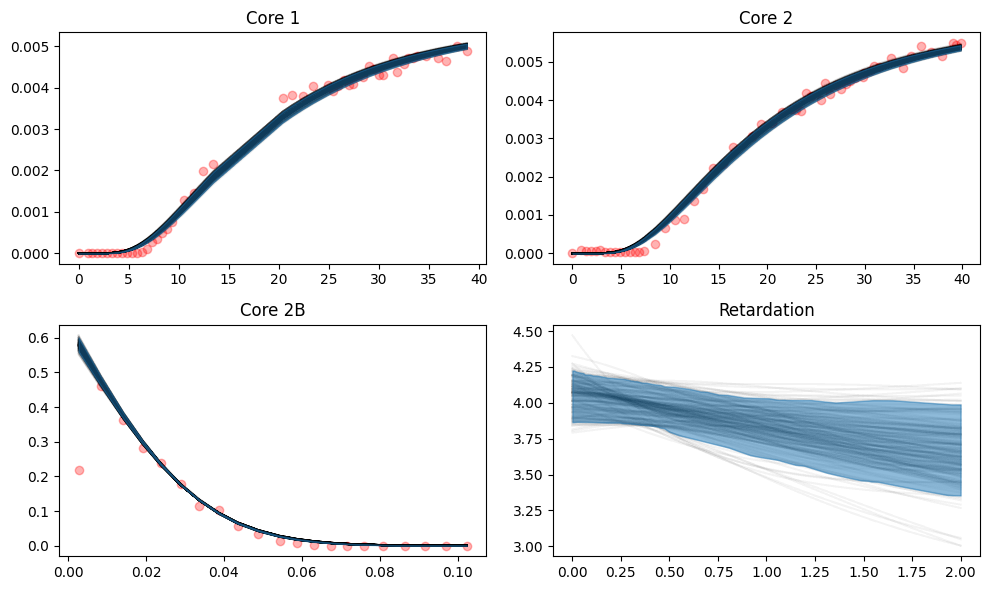

In [15]:
processed_expdata_dir = Path("../data_processed/experimental/SPAN")

span_samples = lib.ExperimentalSamples.from_dir(processed_expdata_dir)
span_weights = nll_estimation.compute_hist_weights(
    core2_data[1],
    span_samples.core2,
    sigma=DATA_SIGMA,
)
print(f"{np.std(span_weights)=}")

span_core1_PI_90 = get_weighted_interval(span_samples.core1, 0.9, weights=span_weights)
span_core2_PI_90 = get_weighted_interval(span_samples.core2, 0.9, weights=span_weights)
span_core2b_PI_90 = get_weighted_interval(
    span_samples.core2b, 0.9, weights=span_weights
)
span_ret_PI_90 = get_weighted_interval(span_samples.ret_y, 0.9, weights=span_weights)

fig, axs = span_samples.plot()

axs[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)

axs[0].fill_between(core1_data[0], *span_core1_PI_90, color="C0", alpha=0.5, zorder=100)
axs[1].fill_between(core2_data[0], *span_core2_PI_90, color="C0", alpha=0.5, zorder=100)
axs[2].fill_between(
    core2b_data[0], *span_core2b_PI_90, color="C0", alpha=0.5, zorder=100
)
axs[3].fill_between(
    span_samples.ret_x, *span_ret_PI_90, color="C0", alpha=0.5, zorder=100
)

fig.savefig("../paper/figs/finn_span_samples.png")
plt.tight_layout()
plt.show()

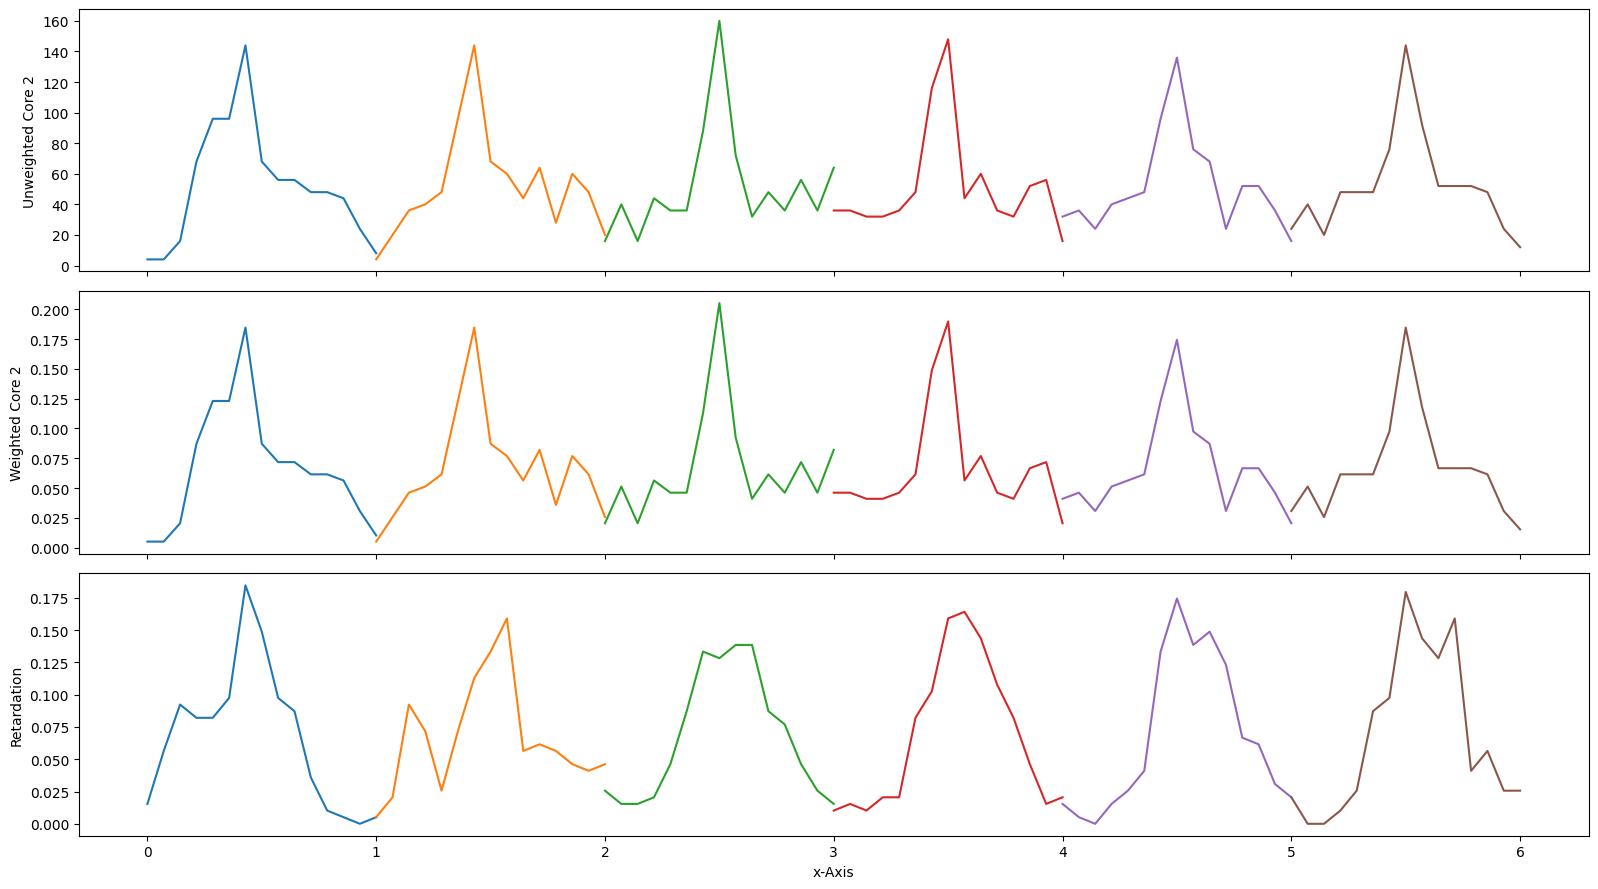

In [16]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)
axs[0].set_ylabel("Unweighted Core 2")
axs[1].set_ylabel("Weighted Core 2")
axs[2].set_ylabel("Retardation")
axs[-1].set_xlabel("x-Axis")
hist_kwargs = dict(fit_guassians=False, bins=15)
hists_over_x(span_samples.core2, ax=axs[0], **hist_kwargs)
hists_over_x(span_samples.core2, ax=axs[1], weights=span_weights, **hist_kwargs)
hists_over_x(span_samples.ret_y, ax=axs[2], weights=span_weights, **hist_kwargs)
plt.tight_layout()
plt.show()

In [17]:
# just to check if both functions do about the same thing...
print(nll_estimation.weighted_percentile(span_samples.ret_y[:, 20], span_weights, 0.05))
print(nll_estimation.compute_PI(span_samples.ret_y[:, 20], span_weights, 0.05))

3.866305
3.8749068


## PI3NN-SPAN (or better name Data-SPAN?)

dataspan_samples.core2.shape=(69, 55)
np.std(dataspan_weights)=2.1535465375723075e-06


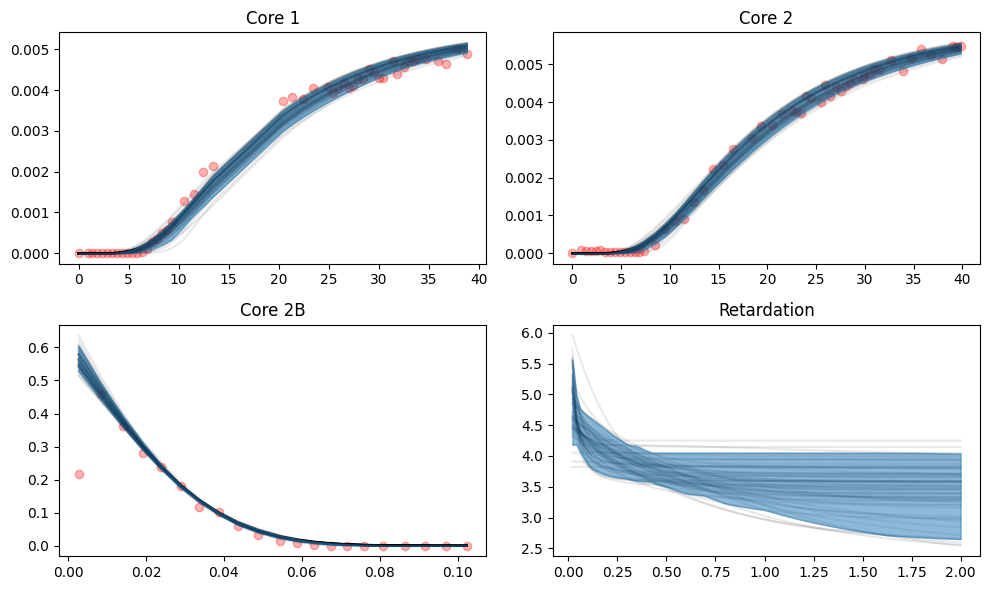

In [18]:
dataspan_samples = lib.ExperimentalSamples.from_dir(
    Path("../data_processed/experimental/DataSPAN")
)
print(f"{dataspan_samples.core2.shape=}")
fig, axs = dataspan_samples.plot()

axs[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)


# weighting =========================
dataspan_weights = nll_estimation.compute_hist_weights(
    core2_data[1],
    dataspan_samples.core2,
    sigma=DATA_SIGMA,
)
print(f"{np.std(dataspan_weights)=}")

dataspan_core1_PI_90 = get_weighted_interval(
    dataspan_samples.core1, 0.9, weights=dataspan_weights
)
dataspan_core2_PI_90 = get_weighted_interval(
    dataspan_samples.core2, 0.9, weights=dataspan_weights
)
dataspan_core2b_PI_90 = get_weighted_interval(
    dataspan_samples.core2b, 0.9, weights=dataspan_weights
)
dataspan_ret_PI_90 = get_weighted_interval(
    dataspan_samples.ret_y, 0.9, weights=dataspan_weights
)


axs[0].fill_between(
    core1_data[0], *dataspan_core1_PI_90, color="C0", alpha=0.5, zorder=100
)
axs[1].fill_between(
    core2_data[0], *dataspan_core2_PI_90, color="C0", alpha=0.5, zorder=100
)
axs[2].fill_between(
    core2b_data[0], *dataspan_core2b_PI_90, color="C0", alpha=0.5, zorder=100
)
axs[3].fill_between(
    dataspan_samples.ret_x, *dataspan_ret_PI_90, color="C0", alpha=0.5, zorder=100
)
# ===================================


fig.savefig("../paper/figs/finn_dataspan_samples.png")
plt.tight_layout()
plt.show()

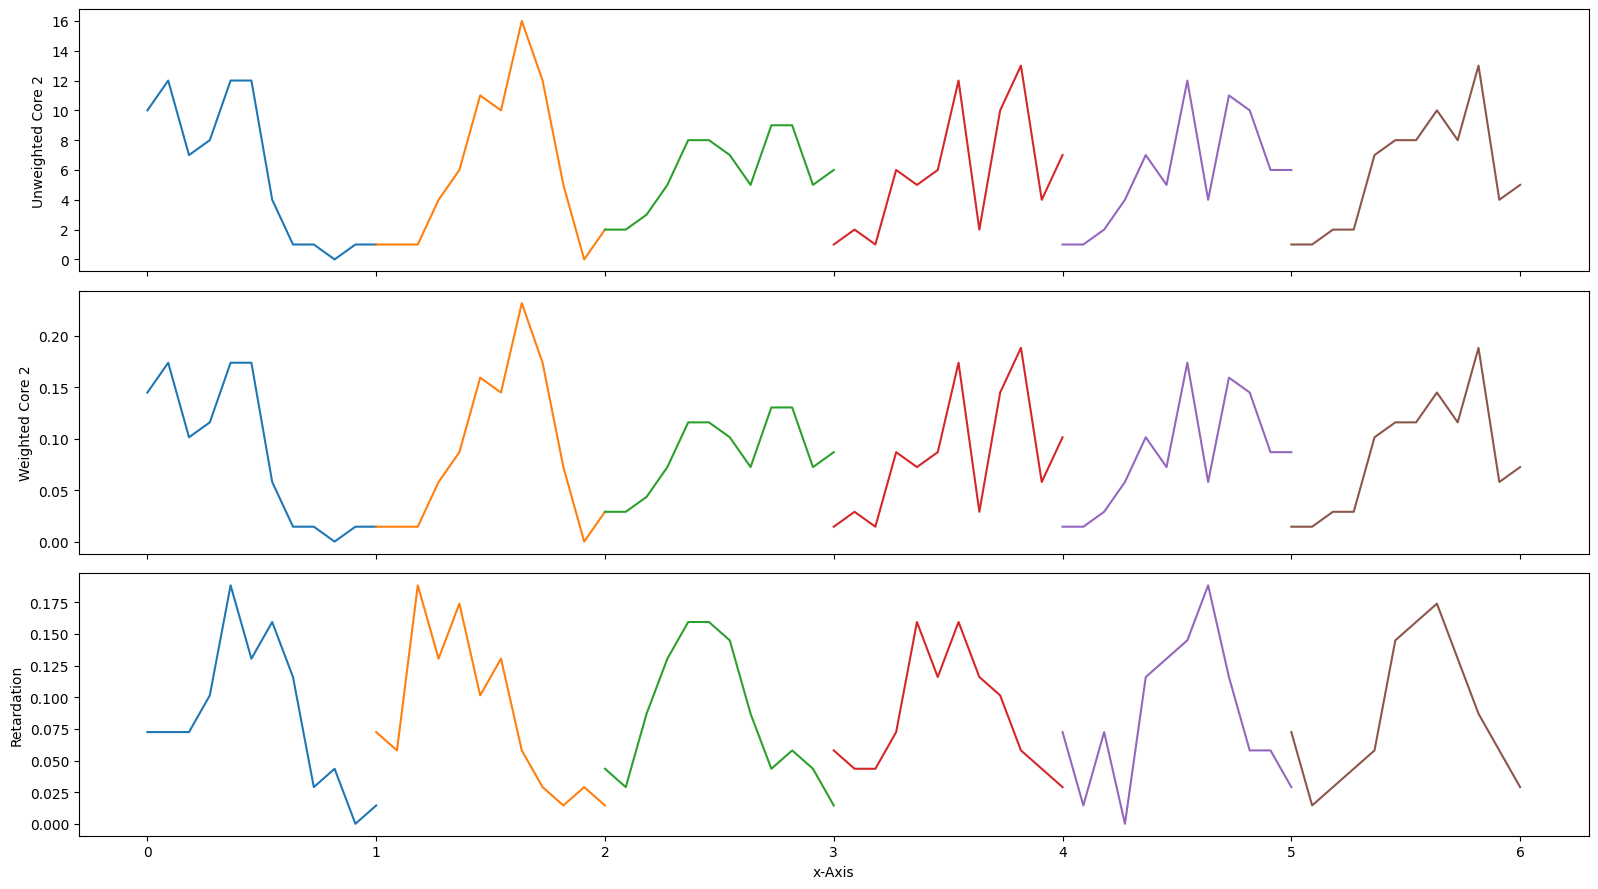

In [19]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)
axs[0].set_ylabel("Unweighted Core 2")
axs[1].set_ylabel("Weighted Core 2")
axs[2].set_ylabel("Retardation")
axs[-1].set_xlabel("x-Axis")
hist_kwargs = dict(fit_guassians=False, bins=12)
hists_over_x(dataspan_samples.core2, ax=axs[0], **hist_kwargs)
hists_over_x(dataspan_samples.core2, ax=axs[1], weights=dataspan_weights, **hist_kwargs)
hists_over_x(dataspan_samples.ret_y, ax=axs[2], weights=dataspan_weights, **hist_kwargs)
plt.tight_layout()
plt.show()

## Data-SPAN + SPAN

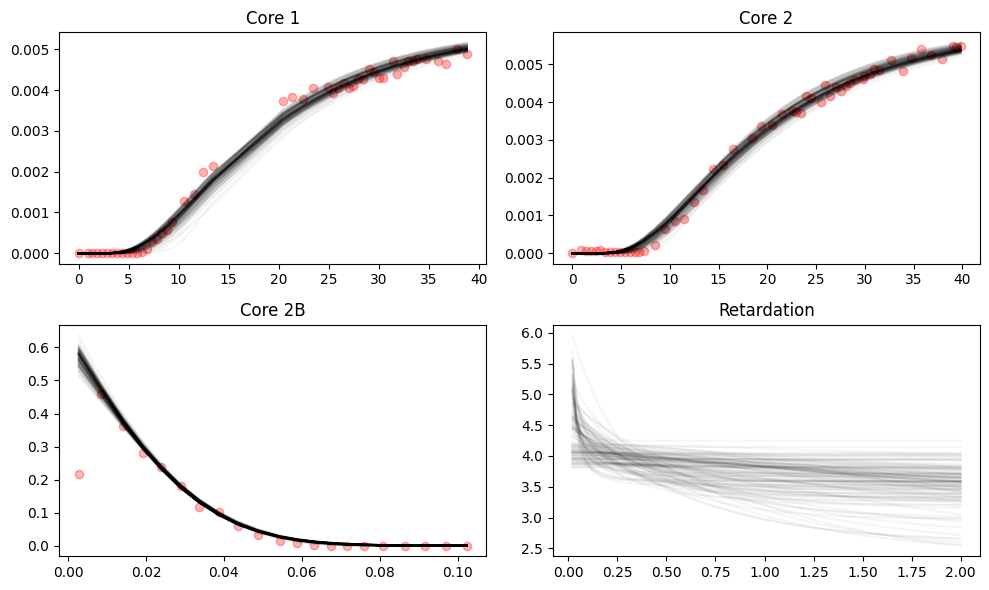

In [20]:
STEP = 10  # temporary fix, see readme on how to do it properly
downsampled_span_ret_samples = np.array(
    [
        np.interp(dataspan_samples.ret_x, span_samples.ret_x, span_samples.ret_y[i, :])
        for i in range(0, span_samples.ret_y.shape[1], STEP)
    ]
)
fullspan_samples = lib.ExperimentalSamples(
    core1=np.concatenate([dataspan_samples.core1, span_samples.core1[::STEP]]),
    core2=np.concatenate([dataspan_samples.core2, span_samples.core2[::STEP]]),
    core2b=np.concatenate([dataspan_samples.core2b, span_samples.core2b[::STEP]]),
    ret_y=np.concatenate([dataspan_samples.ret_y, downsampled_span_ret_samples]),
    ret_x=dataspan_samples.ret_x,
)
fig, axs = fullspan_samples.plot()

axs[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)

fig.savefig("../paper/figs/finn_fullspan_samples.png")
plt.tight_layout()
plt.show()

# Comparisons

In [21]:
from matplotlib.lines import Line2D

# # Plotting the samples
# mcmc_samples.plot(axs, line_kwargs=dict(alpha=0.2, color="C1"), only_outlines=True)
# span_samples.plot(axs, line_kwargs=dict(alpha=0.2, color="C2"), only_outlines=True)

# # Creating proxy artists for legend
# legend_elements = [
#     Line2D([0], [0], color="C1", label="MCMC Samples"),
#     Line2D([0], [0], color="C2", label="SPAN Samples"),
# ]

# # Adding the legend to the figure (or specify an axis if preferred)
# fig.legend(handles=legend_elements, loc="upper center", ncol=2, fontsize="medium")

# plt.tight_layout()
# plt.show()

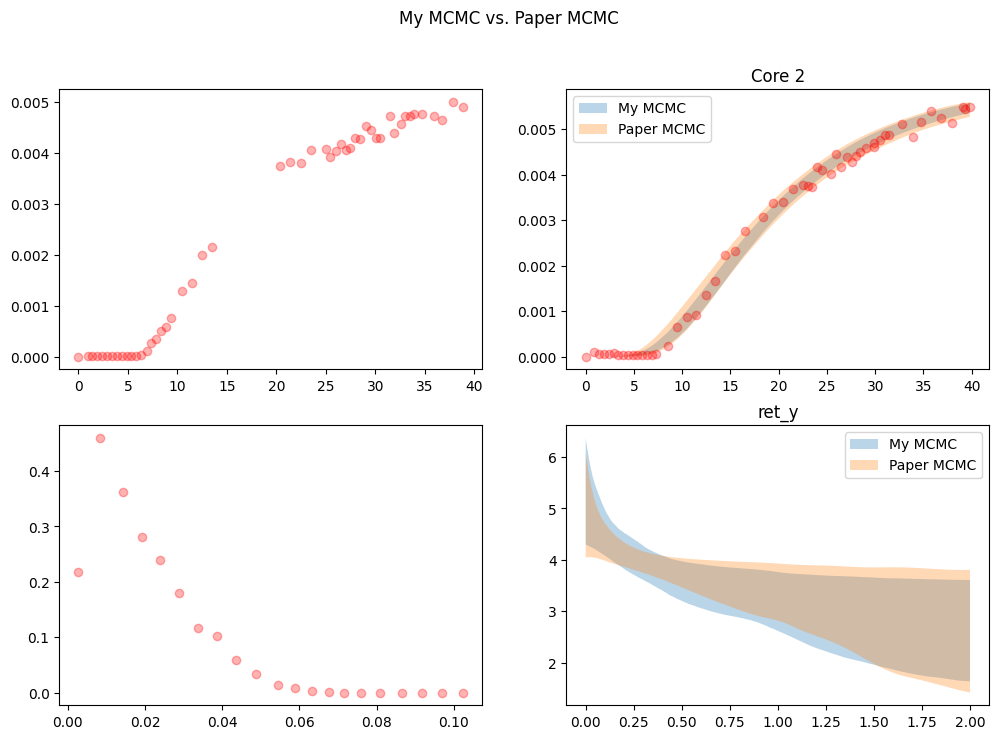

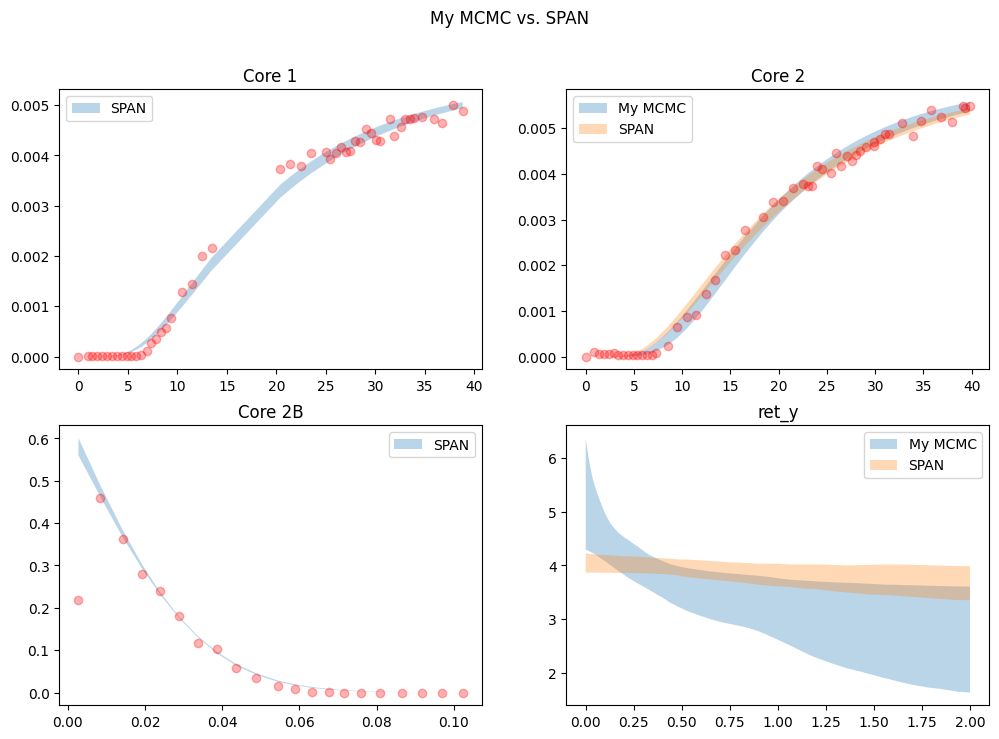

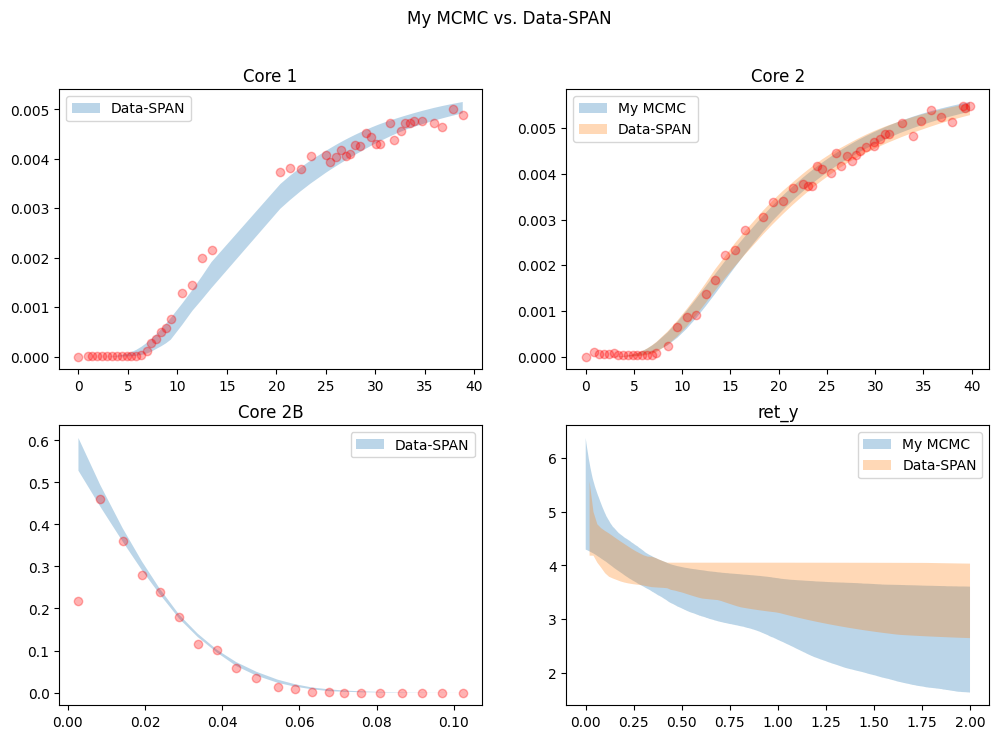

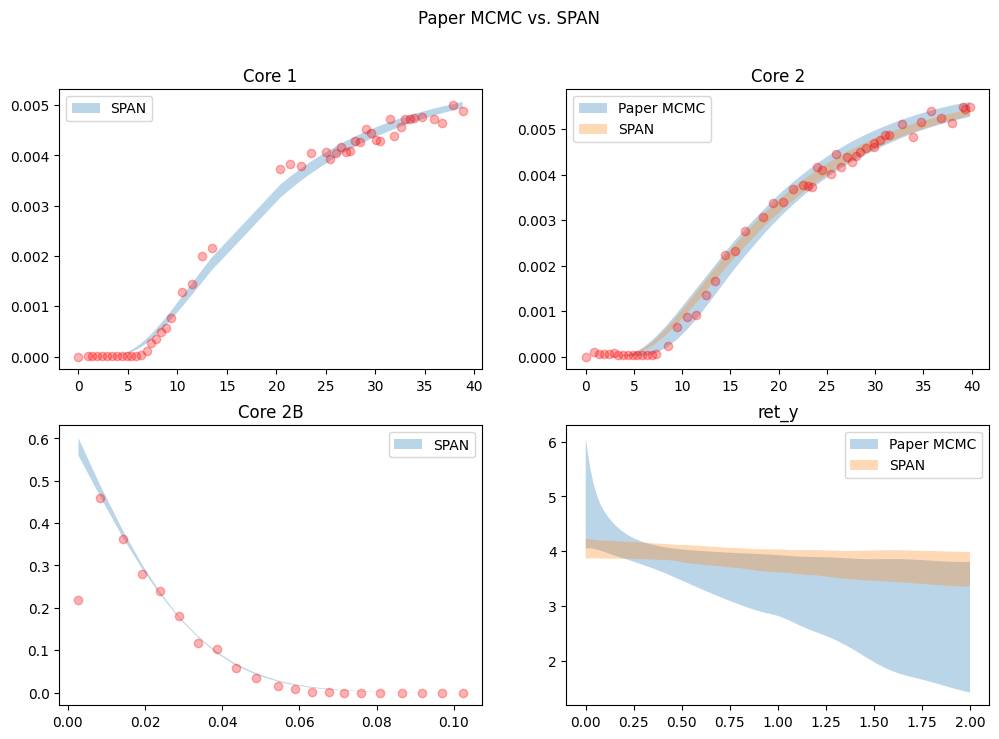

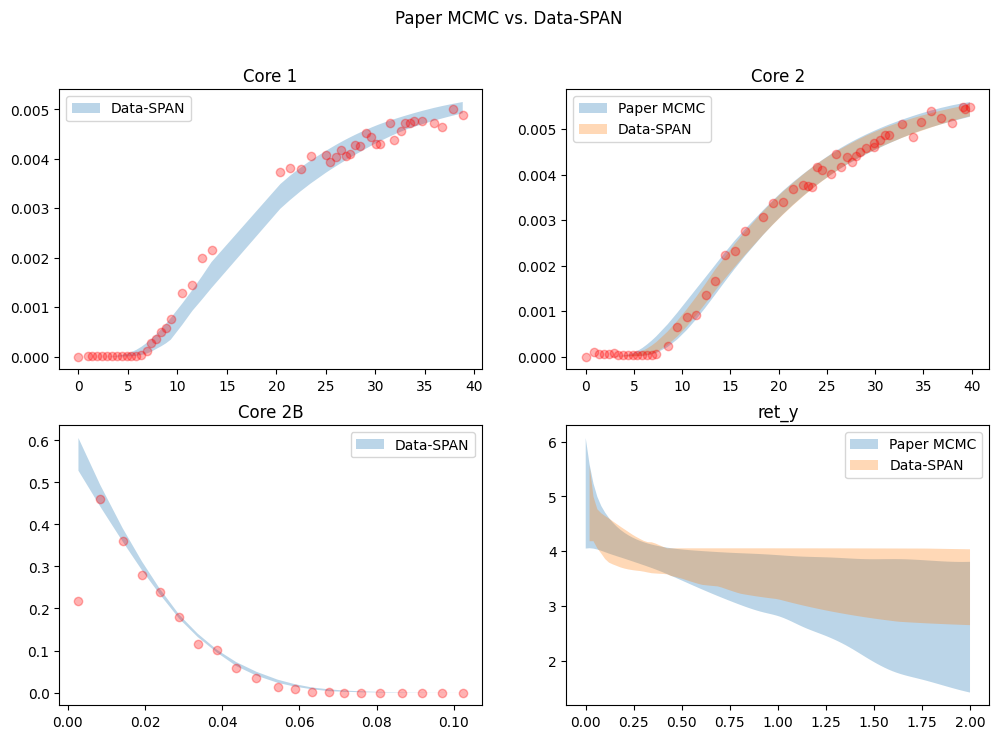

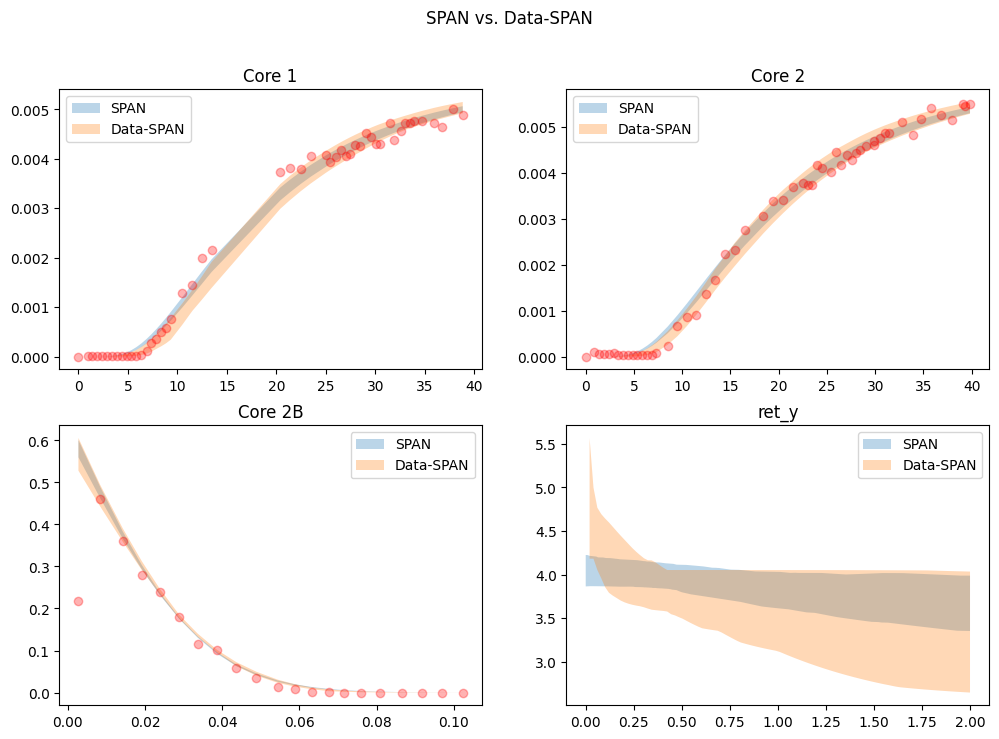

In [22]:
import itertools
from typing import Optional

import matplotlib.pyplot as plt

USED_QUANTILE = 0.9  # Paper says it uses 95%, but the code shows 90%.
assert USED_QUANTILE == 0.9


def upper_lower_from_name(
    samples: lib.ExperimentalSamples, name: str, attr_name: str
) -> tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    if name in ["Data-SPAN", "SPAN", "Full SPAN"]:
        # These two should in theory cover the whole distribution, thus I compute the quantiles
        weights = {
            "Data-SPAN": dataspan_weights,
            "SPAN": span_weights,
            "Full SPAN": dataspan_weights,  # FIXME
        }[name]
        lower, upper = get_weighted_interval(
            getattr(samples, attr_name), USED_QUANTILE, weights
        )
    elif name == "Paper MCMC":
        upper, lower = getattr(samples, attr_name)
    elif name == "My MCMC":
        if attr_name in ["core1", "core2b"]:
            upper, lower = None, None  # TODO: Compute the samples for core1 and core2b
        else:
            upper = np.quantile(
                getattr(samples, attr_name), (1 + USED_QUANTILE) / 2, axis=0
            )
            lower = np.quantile(
                getattr(samples, attr_name), (1 - USED_QUANTILE) / 2, axis=0
            )
    else:
        raise ValueError(f"Unknown method '{name}'")
    return upper, lower


methods = [
    (mcmc_samples, "My MCMC"),
    (paper_mcmc_samples, "Paper MCMC"),
    (span_samples, "SPAN"),
    (dataspan_samples, "Data-SPAN"),
    # (fullspan_samples, "Full SPAN"),  # TODO: uncomment once these are properly generated
]
for method1, method2 in itertools.combinations(methods, 2):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
    fig.suptitle(f"{method1[1]} vs. {method2[1]}")

    axs.flat[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
    axs.flat[1].scatter(*core2_data, color="red", alpha=0.3)
    axs.flat[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)

    for method in [method1, method2]:
        samples, name = method

        for ax_idx, data_name in enumerate(["Core 1", "Core 2", "Core 2B", "ret_y"]):
            attr_name = data_name.replace(" ", "").lower()
            upper, lower = upper_lower_from_name(samples, name, attr_name)
            if upper is None or lower is None:
                continue

            if attr_name == "ret_y":
                x = samples.ret_x
            elif attr_name == "core2b":
                x = np.linspace(
                    0,
                    lib.load_exp_conf("Core 2B")["X"],
                    int(lib.load_exp_conf("Core 2B")["Nx"]),
                )
                if x.shape[0] != lower.shape[0]:
                    x = lib.load_exp_data_numpy("Core 2B")[0]
            else:
                x = lib.load_exp_data_numpy(data_name)[0]
            # print(x.shape, lower.shape, upper.shape, attr_name, name)
            axs.flat[ax_idx].fill_between(
                x, lower, upper, **PI_PLOT_KWARGS, label=f"{name}"
            )
            axs.flat[ax_idx].set_title(f"{data_name}")
            axs.flat[ax_idx].legend()

    fig.savefig(f"../paper/figs/finn_{method1[1]}vs{method2[1]}_PIs.png")

# Likelihood

In [23]:
core2_data[1].shape, mcmc_samples.core2.shape

((55,), (10000, 55))

In [63]:
SKIP = 1

   My MCMC: -7.105830793245051
      SPAN: -6.414646922215222
 Data-SPAN: -7.1406942858257105
      Real: -7.502364063325188


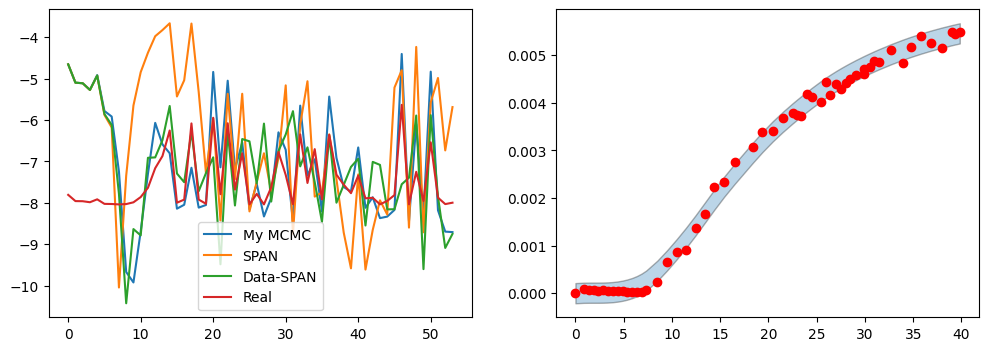

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))


nll_method = nll_estimation.nll_baseline

if (None, "Real") not in methods:
    methods.append((None, "Real"))

data = core2_data[1]
distributions = [
    stats.norm(loc=mean_core2_paper[i], scale=np.std(data - mean_core2_paper))
    for i in range(len(data))
]
# data = np.array([distr.rvs(size=1) for distr in distributions])
gauss_upper_90s = np.array([distr.ppf(0.95) for distr in distributions])
gauss_lower_90s = np.array([distr.ppf(0.05) for distr in distributions])

ax2.plot(core2_data[0], data, "ro")
ax2.fill_between(
    core2_data[0], gauss_lower_90s, gauss_upper_90s, alpha=0.3, edgecolor="k"
)

for method in methods:
    samples, name = method

    if name == "Paper MCMC":
        continue

    nlls = []
    for i in range(SKIP, len(data)):
        datapoint = np.array([data[i]])
        # print(name, i)
        if name == "Real":
            nlls.append(-distributions[i].logpdf(datapoint).squeeze())
        else:
            nlls.append(nll_method(samples.core2[:, i], datapoint).squeeze())
    nlls = np.array(nlls)

    print(f"{name:>10}: {nlls.mean()}")
    ax1.plot(nlls, label=name)

ax1.legend()
plt.show()

# Reliability curves

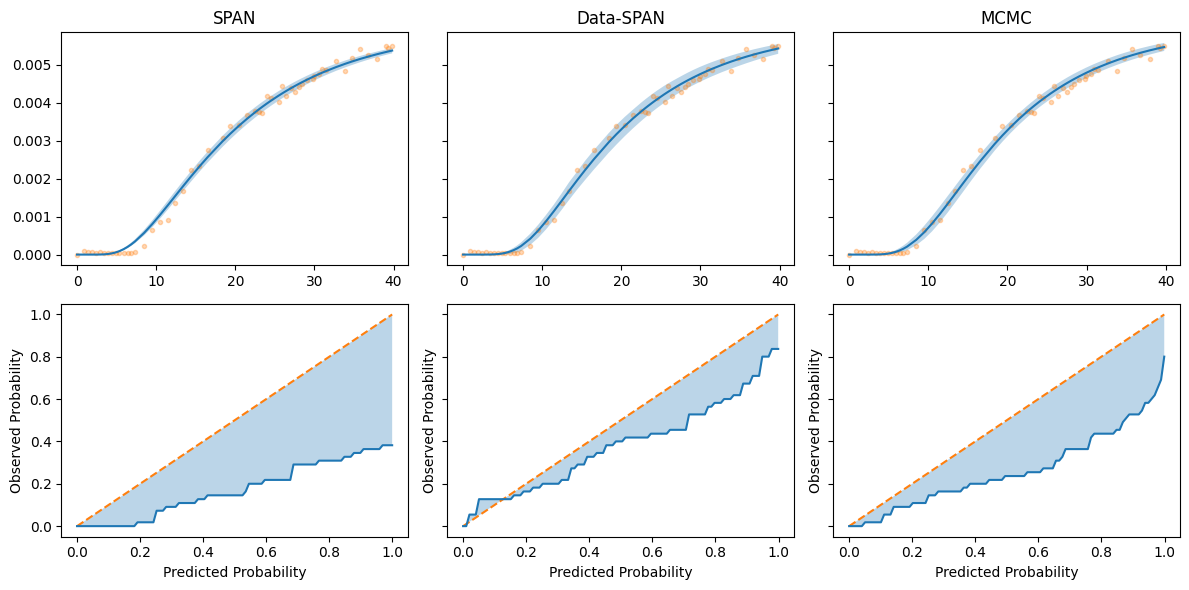

In [ ]:
def reliability_curve(samples, weights, title: str, axs=None):
    mean = samples.mean(axis=0)
    x = core2_data[0]
    y = core2_data[1]

    if axs is None:
        fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

    axs[0].set_title(title)
    FILL_PARAMS = dict(color="C0", alpha=0.3, edgecolor="none")
    axs[0].plot(x, y, ".", color="C1", alpha=0.3)
    axs[0].plot(x, mean, color="C0")
    axs[0].fill_between(
        x,
        *get_weighted_interval(samples, 0.9, weights),
        **FILL_PARAMS,
    )

    calibration_curve_x = np.linspace(0, 0.999, 100, endpoint=True)
    calibration_curve_y = [0.0]
    for p in calibration_curve_x[1:]:
        lower, upper = get_weighted_interval(samples, p, weights)
        n_inside = np.count_nonzero((y < upper) & (y > lower))
        calibration_curve_y.append(n_inside / y.shape[0])

    optimal_calibration_curve_y = calibration_curve_x.copy()
    axs[1].plot(calibration_curve_x, optimal_calibration_curve_y, "--", color="C1")
    axs[1].plot(calibration_curve_x, calibration_curve_y, "-", color="C0")
    axs[1].fill_between(
        calibration_curve_x,
        optimal_calibration_curve_y,
        calibration_curve_y,
        **FILL_PARAMS,
    )
    axs[1].set_xlabel("Predicted Probability")
    axs[1].set_ylabel("Observed Probability")

    return plt.gcf(), axs


# below identity -> overconfident
# above identity -> underconfident

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharey="row")

for i, (samples, weights, title) in enumerate(
    [
        (span_samples.core2, span_weights, "SPAN"),
        (dataspan_samples.core2, dataspan_weights, "Data-SPAN"),
        (mcmc_samples.core2, None, "MCMC"),
    ]
):
    reliability_curve(samples, weights, title, axs=axs[:, i])

plt.tight_layout()
plt.show()